This section installs librosa for audio processing and configures Git LFS to handle large audio files. The Donate a Cry Corpus dataset is then cloned from GitHub and its .wav files are downloaded. This prepares the environment for audio preprocessing and LSTM model training.

In [1]:
!pip install librosa==0.9.2

# Install Git LFS (needed for .wav files)
!apt-get install git-lfs -y
!git lfs install

# Clone repo
!git clone https://github.com/gveres/donateacry-corpus.git

# Pull large audio files (wav)
%cd donateacry-corpus
!git lfs pull
%cd /content


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
Git LFS initialized.
Cloning into 'donateacry-corpus'...
remote: Enumerating objects: 1616, done.
remote: Total 1616 (delta 0), reused 0 (delta 0), pack-reused 1616 (from 1)
Receiving objects: 100% (1616/1616), 67.06 MiB | 21.80 MiB/s, done.
Resolving deltas: 100% (43/43), done.
/content/donateacry-corpus
/content


This section imports essential libraries for audio analysis, visualization, and data preparation. librosa handles audio processing, matplotlib supports plotting, and NumPy manages numerical operations. Keras and scikit-learn are used for data preprocessing, splitting, and encoding, while warnings are suppressed for cleaner outputs.

In [2]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')


This function converts all .wav audio files in the input directory into mel-spectrogram images. Each audio file is loaded using librosa, transformed into a mel-spectrogram, and saved as a .png image in the output directory. These images will later serve as input features for the LSTM model.

In [3]:
def create_pngs_from_wavs(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for fname in os.listdir(input_dir):
        if fname.endswith(".wav"):
            wav_path = os.path.join(input_dir, fname)
            png_path = os.path.join(output_dir, fname.replace(".wav", ".png"))

            y, sr = librosa.load(wav_path, sr=None)
            S = librosa.feature.melspectrogram(y=y, sr=sr)
            plt.figure(figsize=(6, 4))
            librosa.display.specshow(librosa.power_to_db(S, ref=np.max), sr=sr, x_axis='time', y_axis='mel')
            plt.axis("off")
            plt.savefig(png_path, bbox_inches="tight", pad_inches=0)
            plt.close()


This section processes all audio files across the defined categories—belly_pain, burping, discomfort, hungry, and tired. Each .wav file is converted into a mel-spectrogram image using the previously defined function and stored in corresponding output folders, preparing the dataset for model training.

In [4]:
base_path = "/content/donateacry-corpus/donateacry_corpus_cleaned_and_updated_data"
output_base = "/content/processed"

categories = ["belly_pain", "burping", "discomfort", "hungry", "tired"]

for cat in categories:
    in_dir = os.path.join(base_path, cat)
    out_dir = os.path.join(output_base, cat)
    create_pngs_from_wavs(in_dir, out_dir)
    print(f"Done: {cat}")


Done: belly_pain
Done: burping
Done: discomfort
Done: hungry
Done: tired


This code defines a function load_images_from_path that loads all .png images from a specified folder, resizes them to 224×224, converts them to arrays, and assigns them a given label. It then iterates through all categories, loads their images and labels, and combines them into NumPy arrays x and y, which are finally printed to show the dataset shapes. Essentially, it prepares labeled image data for machine learning tasks.

In [5]:
def load_images_from_path(path, label):
    images = []
    labels = []
    for file in os.listdir(path):
        if file.endswith(".png"):
            img = image.load_img(os.path.join(path, file), target_size=(224, 224))
            img_array = image.img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load all categories
x, y = [], []
for idx, cat in enumerate(categories):
    img_dir = os.path.join(output_base, cat)
    imgs, labels = load_images_from_path(img_dir, idx)
    x.extend(imgs)
    y.extend(labels)

x = np.array(x)
y = np.array(y)

print("Loaded data:")
print("X shape:", x.shape)
print("Y shape:", y.shape)


Loaded data:
X shape: (457, 224, 224, 3)
Y shape: (457,)


This code first ensures that the image and label lists are converted to NumPy arrays. It then splits the dataset into training and testing sets (10% for testing) while maintaining the label distribution using stratification. The pixel values of the images are normalized to the [0, 1] range, and the labels are one-hot encoded for use in classification tasks. Finally, it prints the shapes of the processed datasets to confirm the data preparation.

In [6]:
# Ensure numpy arrays
x = np.array(x)
y = np.array(y)

# Split train/test with stratify
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=0, stratify=y
)

# Normalize pixel values
x_train_norm = x_train.astype("float32") / 255.0
x_test_norm = x_test.astype("float32") / 255.0

# One-hot encode labels
y_train_encoded = to_categorical(y_train, num_classes=len(np.unique(y)))
y_test_encoded = to_categorical(y_test, num_classes=len(np.unique(y)))

print("Shapes:")
print("x_train_norm:", x_train_norm.shape)
print("x_test_norm:", x_test_norm.shape)
print("y_train_encoded:", y_train_encoded.shape)
print("y_test_encoded:", y_test_encoded.shape)


Shapes:
x_train_norm: (411, 224, 224, 3)
x_test_norm: (46, 224, 224, 3)
y_train_encoded: (411, 5)
y_test_encoded: (46, 5)


This code defines a convolutional neural network (CNN) using TensorFlow/Keras for image classification. It starts with input preprocessing layers (Resizing and Normalization), followed by convolutional layers with ReLU activations, max pooling, and dropout for feature extraction and regularization. A custom RandomFourierFeatures layer projects the flattened features into a higher-dimensional space using sine and cosine transformations. The network ends with a dense layer with softmax activation for multi-class classification. Finally, the model is compiled with the AdamW optimizer and categorical cross-entropy loss.

In [7]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Normalization, Resizing, InputLayer
from tensorflow.keras.optimizers import AdamW

class RandomFourierFeatures(tf.keras.layers.Layer):
    def __init__(self, output_dim, scale=10.0, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dim
        self.scale = scale

    def build(self, input_shape):
        dim = int(input_shape[-1])
        self.W = self.add_weight(
            shape=(dim, self.output_dim),
            initializer=tf.keras.initializers.RandomNormal(stddev=1.0/self.scale),
            trainable=False
        )

    def call(self, x):
        projection = tf.matmul(x, self.W)
        return tf.concat([tf.sin(projection), tf.cos(projection)], axis=-1)

model = Sequential()
model.add(InputLayer(input_shape=(224, 224, 3)))
model.add(Resizing(64, 64))
model.add(Normalization())
model.add(Conv2D(64, 3, strides=1, activation='relu'))
model.add(Conv2D(128, 3, strides=1, activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(RandomFourierFeatures(5))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer=AdamW(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()




Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 64, 64, 3)      │             7 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 62, 62, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_fourier_features         │ (None, 10)             │       576,000 │
│ (RandomFourierFeatures)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │            55 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 651,710 (2.49 MB)

 Trainable params: 75,703 (295.71 KB)

 Non-trainable params: 576,007 (2.20 MB)

This code sets up a learning rate scheduler using ReduceLROnPlateau, which reduces the optimizer’s learning rate by half if the validation accuracy does not improve for 2 consecutive epochs, with a minimum learning rate of 0.006. The model is then trained for 50 epochs on the normalized training data (x_train_norm, y_train_encoded) while validating on the test set (x_test_norm, y_test_encoded). The training history, including loss and accuracy metrics, is stored in hist for later analysis or visualization.

In [8]:

from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=0.5,patience=2,min_lr=0.006,verbose=1)

hist = model.fit(x_train_norm, y_train_encoded, validation_data=(x_test_norm, y_test_encoded), epochs=50,callbacks=[reduce_lr])


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 484ms/step - accuracy: 0.2517 - loss: 1.7892 - val_accuracy: 0.5435 - val_loss: 1.3698 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3958 - loss: 1.5580 - val_accuracy: 0.6522 - val_loss: 0.9628 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5114 - loss: 1.3553 - val_accuracy: 0.7609 - val_loss: 0.8425 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6709 - loss: 1.0959 - val_accuracy: 0.7826 - val_loss: 0.7879 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6988 - loss: 0.9698 - val_accuracy: 0.7609 - val_loss: 0.9068 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7034 - loss: 1.0376 - val_accuracy: 0.8261 - val_loss: 0.7291 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7814 - loss: 0.8947 - val_a

This code visualizes the model’s training performance by plotting the accuracy over epochs. It extracts the training (acc) and validation (val_acc) accuracy from the training history, then plots them against epoch numbers. The plot uses different line styles for training and validation, includes labels, a title, and a legend, allowing easy comparison of how the model’s accuracy evolves during training.

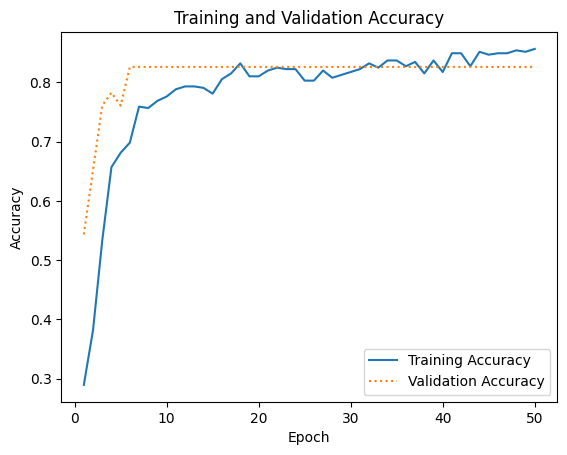

In [9]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()
plt.show()

This code provides a way to make live predictions on audio files using a trained model. The audio_to_mel function converts a .wav audio signal into a normalized Mel-spectrogram image with three channels, resized to 224×224. The predict_live function allows the user to upload an audio file, processes it into a Mel image, feeds it to the model, and outputs the predicted class along with its confidence score.

In [10]:

import numpy as np
import librosa
from google.colab import files

def audio_to_mel(audio, sr=16000, n_mels=224):
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    mel_resized = librosa.util.fix_length(mel_spec_db, size=224, axis=1)

    mel_resized = (mel_resized - mel_resized.min()) / (mel_resized.max() - mel_resized.min())

    mel_rgb = np.stack([mel_resized, mel_resized, mel_resized], axis=-1)
    return mel_rgb

def predict_live(model):
    print("Upload a .wav audio file:")
    uploaded = files.upload()
    audio_path = list(uploaded.keys())[0]

    audio, sr = librosa.load(audio_path, sr=16000)

    mel_img = audio_to_mel(audio, sr=sr)
    mel_input = np.expand_dims(mel_img, axis=0)

    output = model(mel_input, training=False)

    if isinstance(output, dict):
        if 'logits' in output:
            preds = output['logits'].numpy()
        else:
            preds = list(output.values())[0].numpy()
    else:
        preds = output.numpy()

    if preds.ndim == 1:
        class_idx = np.argmax(preds)
    else:
        class_idx = np.argmax(preds, axis=1)[0]

    print(f"Predicted class: {class_idx}, Confidence: {np.max(preds):.2f}")
    return class_idx, preds


This code uses the predict_live function to classify a newly uploaded audio file and stores the predicted class index and confidence scores. It then maps the numeric class index to a human-readable label using the class_labels dictionary and prints the predicted class name along with its confidence.

In [11]:
class_idx, preds = predict_live(model)
class_labels = {
    0: "belly_pain",
    1: "burping",
    2: "discomfort",
    3: "hungry",
    4: "tired"
}
print(f"Predicted class: {class_labels[class_idx]}, Confidence: {np.max(preds):.2f}")

Upload a .wav audio file:


Saving 643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138591-1.0-m-72-bp.wav to 643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138591-1.0-m-72-bp.wav
Predicted class: 3, Confidence: 0.41
Predicted class: hungry, Confidence: 0.41


Spectrum Visualization

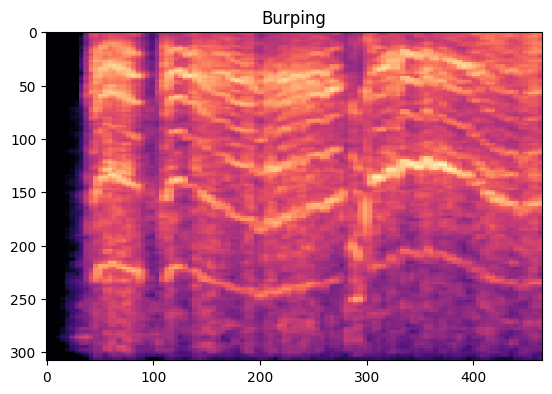

In [13]:

from PIL import Image
plt.title("Burping")
plt.imshow(Image.open("/content/processed/burping/5afc6a14-a9d8-45f8-b31d-c79dd87cc8c6-1430757039803-1.7-m-48-bu.png"))


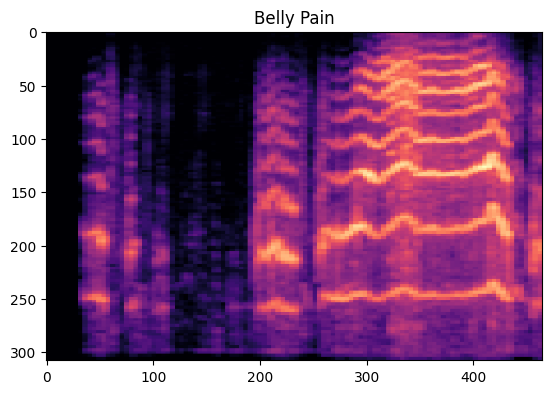

In [15]:
plt.title("Belly Pain")
plt.imshow(Image.open("/content/processed/belly_pain/549a46d8-9c84-430e-ade8-97eae2bef787-1430130772174-1.7-m-48-bp.png"))

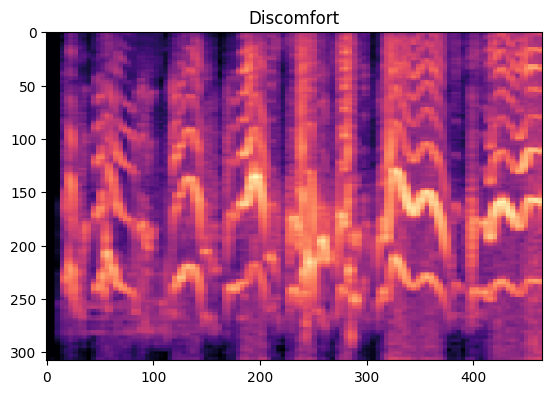

In [16]:

plt.title("Discomfort")
plt.imshow(Image.open("/content/processed/discomfort/10A40438-09AA-4A21-83B4-8119F03F7A11-1430925142-1.0-f-26-dc.png"))


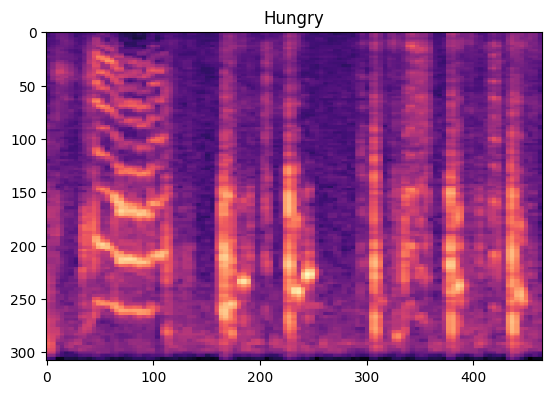

In [17]:

plt.title("Hungry")
plt.imshow(Image.open("/content/processed/hungry/02c3b725-26e4-4a2c-9336-04ddc58836d9-1430726196216-1.7-m-04-hu.png"))


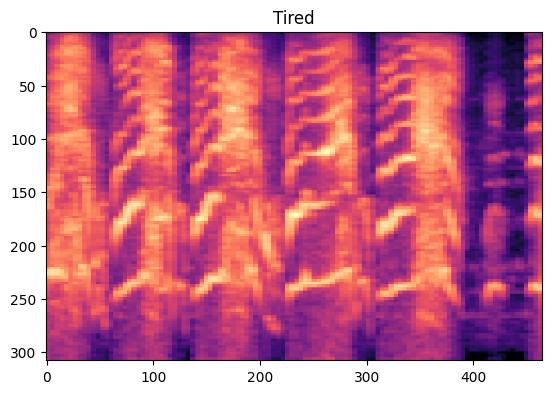

In [18]:

plt.title("Tired")
plt.imshow(Image.open("/content/processed/tired/03ADDCFB-354E-416D-BF32-260CF47F7060-1433658024-1.1-f-04-ti.png"))


This code computes and visualizes the confusion matrix for the trained model’s predictions on the test set. It first predicts class labels for x_test_norm and compares them with the true labels y_test. The resulting confusion matrix is displayed using a heatmap with annotations, showing how well the model classified each category and highlighting misclassifications.

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 467ms/step


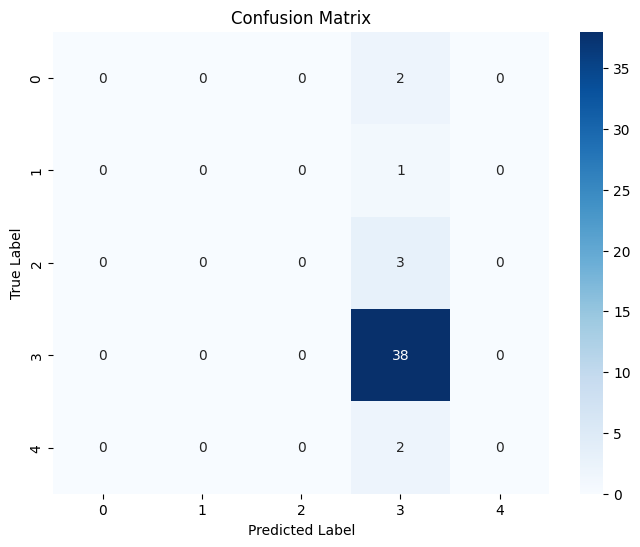

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Replace these with your actual variable names
y_true = y_test        # True labels
y_pred = np.argmax(model.predict(x_test_norm), axis=1)  # Predicted labels

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

This code computes and visualizes the multi-class ROC curves for the trained model. It first binarizes the true labels and obtains predicted probabilities for each class. Then, for each class, it calculates the false positive rate (FPR), true positive rate (TPR), and the area under the curve (AUC). Finally, it plots the ROC curves for all classes with AUC values, providing a visual assessment of the model’s discriminative ability across categories.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


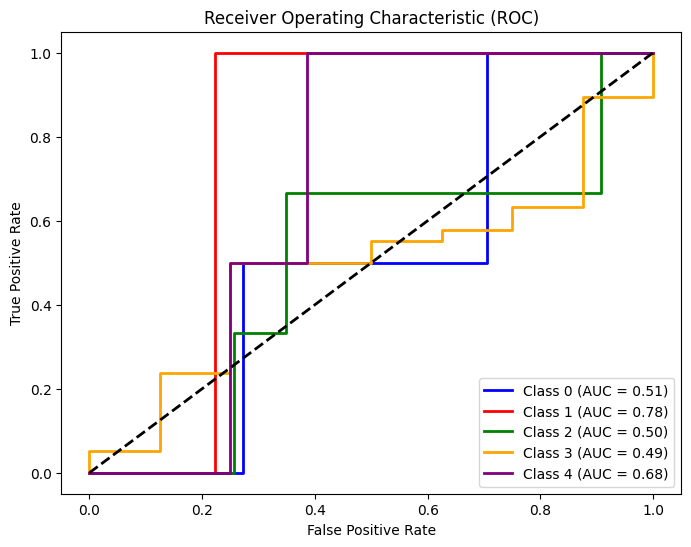

In [20]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize labels for multi-class ROC
y_test_bin = label_binarize(y_true, classes=range(len(np.unique(y_true))))
y_pred_prob = model.predict(x_test_norm)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

This code computes and plots the Precision-Recall (PR) curves for each class in a multi-class classification setting. For every class, it calculates precision and recall values from the true binarized labels and predicted probabilities, and computes the Area Under the PR Curve (AUPR). The resulting plot visualizes the trade-off between precision and recall for all classes, providing insight into the model’s performance, especially for imbalanced datasets.

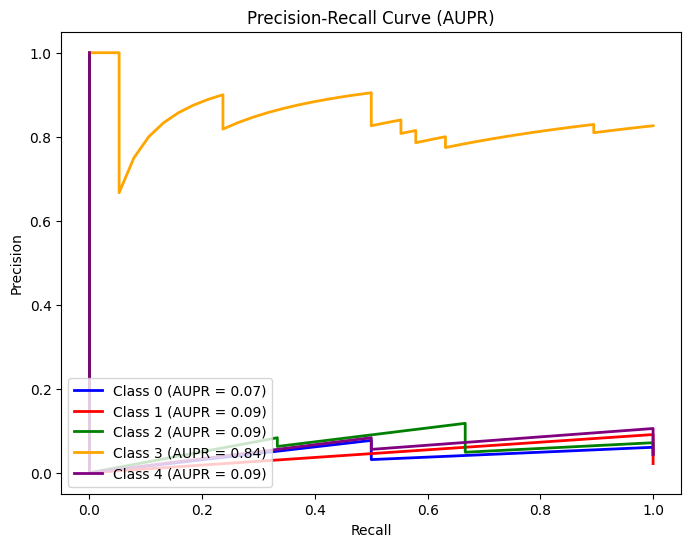

In [21]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8,6))
for i, color in zip(range(n_classes), colors):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
    aupr = average_precision_score(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, lw=2, color=color,
             label='Class {0} (AUPR = {1:0.2f})'.format(i, aupr))

plt.title('Precision-Recall Curve (AUPR)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()

This code visualizes the training progress of the model. The first plot shows how the training and validation accuracy evolve over epochs, helping to detect overfitting or underfitting. The second plot shows the training and validation loss over epochs, providing insight into how well the model is optimizing the loss function during training. These plots are useful for evaluating model performance and diagnosing training issues.

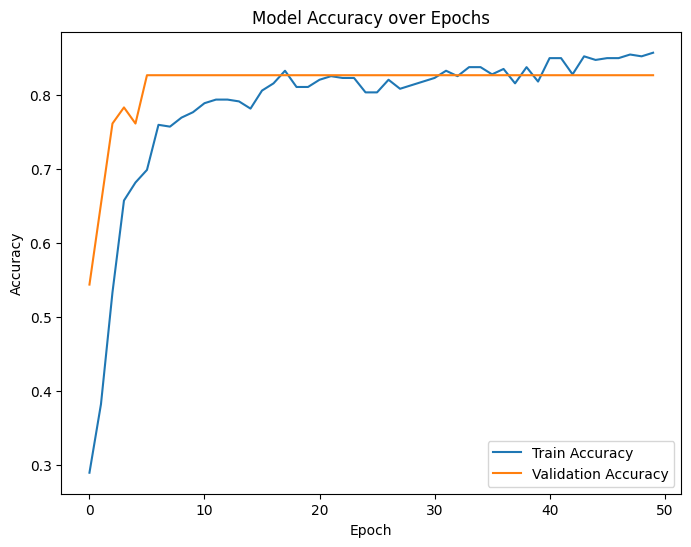

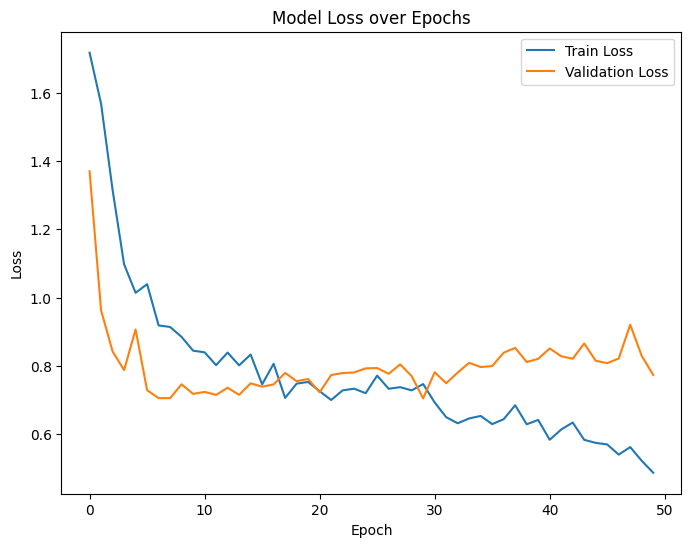

In [22]:
# Assuming: hist = model.fit(...)

plt.figure(figsize=(8,6))
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

This code calculates key classification metrics—accuracy, precision, recall, and F1 score—using the true labels (y_true) and predicted labels (y_pred). It then visualizes these metrics in a bar chart with different colors for each metric, displaying the numerical scores above the bars. This provides a clear summary of the model’s overall performance across multiple evaluation criteria, making it easy to compare strengths and weaknesses.

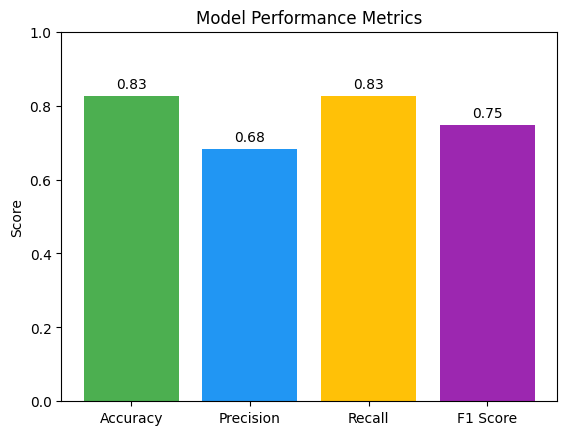

In [23]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt

f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

plt.bar(metrics, values, color=['#4CAF50', '#2196F3', '#FFC107', '#9C27B0'])
plt.ylim(0, 1)
plt.title('Model Performance Metrics')
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', fontsize=10)
plt.ylabel('Score')
plt.show()